# ML Course 2024 |  Medical Expenses Prediction Challenge

This notebook should serve as a starting point to work on the project. Please read the project description first.

In [1]:
# Just so that you don't have to restart the notebook with every change.
%load_ext autoreload
%autoreload 2 

# Set team ID
Important: set your Team ID here. You can find it in CMS.

In [2]:
team_id = "18"  # put your team id here

# [Colab only] Connect to your Google Drive

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# %cd "/content/drive/MyDrive/path/to/your/project"

# Imports

[Colab only] Note: if you need to install any packages, run a code cell with content `!pip install packagename`

In [5]:
from utils import config
from utils.config import PAPER_STYLE

/home/camilo/Repositorios/ml-healthcare-project/utils/config.py:64: UserWarning: opentsne is not available. Using sklearn.manifold.TSNE instead.
  warn("opentsne is not available. Using sklearn.manifold.TSNE instead.")


In [6]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as skm
from prettytable import PrettyTable
from scipy import stats
from scipy.stats import norm, skew  # for some statistics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import (
    SelectKBest,
    VarianceThreshold,
    chi2,
    f_classif,
    mutual_info_classif,
)
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    ShuffleSplit,
    TunedThresholdClassifierCV,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    quantile_transform,
)
from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR, NuSVC, NuSVR
from xgboost import XGBClassifier

from utils import experiments, helpers
from utils import metrics as my_metrics
from utils import plots, scorers
from utils import statistical as st
from utils import tuning
from utils.param_grids import (
    choose_param_grid,
    combine_param_grids,
    construct_param_grids_list,
    make_smaller_param_grid,
)
from utils.transformers import PolynomialColumnTransformer

# Use cuML to use GPU-accelerated models
USE_CUML = False

# Run experiments
RUN_EXPERIMENTS = False
EXECUTE_CORRELATION_ANALYSIS = False
CORRELATION_THRESHOLD = 0.9

# True if no plots should be displayed
NO_PLOTS = False

if config.CUML_INSTALLED and USE_CUML:
    from cuml import LogisticRegression, MBSGDClassifier
    from cuml.common.device_selection import get_global_device_type, set_global_device_type
    from cuml.svm import SVC, SVR

    set_global_device_type("gpu")

    print("cuML's default execution device:", get_global_device_type())

# Constants that define the classification and regression targets
CLF_TARGET = "UTILIZATION"
REG_TARGET = "TOT_MED_EXP"

# Dedicate a fraction of the data for testing (validation is taken care of by CV)
TEST_SIZE = 0.2

# Define a RANDOM_STATE to make outputs deterministic
RANDOM_STATE = 42
helpers.seed_everything(RANDOM_STATE)

/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Data Analysis & Preprocessing**

## Load Data

In a first step, we load the provided training data from the csv file

In [7]:
df_train = pd.read_csv("data/train.csv")
df_train.drop(columns=[REG_TARGET], inplace=True) # drop the regression target

print("The loaded dataset has {} rows and {} columns".format(df_train.shape[0], df_train.shape[1]))

The loaded dataset has 15000 rows and 109 columns


In [8]:
df_train.head()

,RACE,SEX,PANEL,WEIGHT,STUDENT_STAT,MIL_ACTIV_DUTY,HON_DISCHARGE,HEALTH_STAT,MENTAL_HLTH,CHRON_BRONCH,...,ADHD_DIAG,NUM_PRESCR_MEDS,DIFFIC_HEAR,DIFFIC_SEE,SMOK,OVR_FEEL_14,MENTAL_HLTH_SCR,PHY_HLTH_SCR,OVR_FEEL_30,UTILIZATION
0,Non-White,1,19,7205.036720,-1,2,2,2,2,2,...,-1,0,2,2,2,1,43.82,61.41,3,LOW
1,White,1,20,5501.113581,-1,4,2,1,1,2,...,-1,12,2,2,2,0,60.12,54.80,0,LOW
2,White,1,20,16797.708379,-1,4,1,3,1,2,...,-1,20,2,2,2,0,60.35,30.08,0,LOW
3,Non-White,2,19,3605.218411,-1,2,2,3,3,2,...,-1,20,2,2,2,0,58.32,50.22,0,LOW
4,Non-White,1,19,11223.127404,1,2,2,1,2,2,...,2,3,2,2,2,0,62.39,56.71,0,LOW


In [9]:
# Handling missing values
total_missing_values = df_train.isnull().sum().sum()
print(f"Total number of missing values: {total_missing_values}")

Total number of missing values: 0


## Data exploration

In [10]:
print(
    helpers.describe_cols(
        df_train,
        dummy_is_categorical=False,
        consecutive_sequences_are_categorical=False,
        low_unique_int_values_are_categorical=False,
    )
)

+-------------------------+-------------+-----------+--------------------+--------+-----------+-----------+-----------+------------+----------------------------------------------------------+
| Column Name (Total=109) |     Type    |    Mean   | Standard Deviation |  Min   |    25%    |    50%    |    75%    |    Max     |                       Value Counts                       |
+-------------------------+-------------+-----------+--------------------+--------+-----------+-----------+-----------+------------+----------------------------------------------------------+
|           RACE          | Categorical |           |                    |        |           |           |           |            | {'Non-White': '8754 (58.36%)', 'White': '6246 (41.64%)'} |
|       UTILIZATION       | Categorical |           |                    |        |           |           |           |            |    {'HIGH': '3212 (21.41%)', 'LOW': '11788 (78.59%)'}    |
|        ACTIV_LIM        |  Numerical  

In [11]:
categorical_cols, numerical_cols = helpers.categorical_and_numerical_columns(
    df_train,
    consecutive_sequences_are_categorical=False,
    low_unique_int_values_are_categorical=False,
)

# One-Hot encoding for categorical columns (with non-numeric values only)
categorical_encoder, df_train = helpers.handle_categorical_cols(
    df_train, categorical_cols, return_only_encoded=False
)
df_train = df_train.copy()

print(f"Numerical ({len(numerical_cols)}) ", numerical_cols)
print(f"Categorical ({len(categorical_cols)}): ", categorical_cols)
print(f"Number of columns after one-hot encoding: {df_train.shape[1]}")

Numerical (107)  ['DIAB_KIDNY', 'NUM_DEP_OUT_REP_UNT', 'ADV_LAP_BLT', 'TAKE_RISK', 'ARTHR_DIAG', 'LAST_REG_CKP', 'HRT_ATT_DIAG', 'NUM_PRESCR_MEDS', 'MULT_HIGHBP', 'BM_IDX', 'EMPLYR_INS', 'PROB_WBHV', 'PANEL', 'UNION_STAT', 'COGNTV_LIM', 'JNT_PAIN', 'PENSN_PLAN', 'DIAB_INSLN', 'EDU_DEG', 'DIFF_ERRND_ALN', 'EMPHYM_DIAG', 'DOC_TIM_ALN', 'PROB_BILL_PAY', 'PUB_ASST', 'SMOK', 'WHEN_LST_ASTHMA', 'ARTHR_TYPE', 'STUDENT_STAT', 'INSUR_COV', 'DIAB_MED', 'TAX_FORM_TYP', 'APPT_REG_MEDCARE', 'TIME_LAST_PSA', 'ADHD_DIAG', 'CHRON_BRONCH', 'ADV_EAT_HLTHY', 'MENTAL_HLTH', 'BLIND', 'EMPLYMT', 'SPOUSE_PRSNT', 'LAST_FLU_VAC', 'FEEL_DEPRS', 'NO_WORK_WHY', 'HIGH_BP_DIAG', 'STROKE_DIAG', 'WEAR_SEATBLT', 'ADV_EXERCISE_MORE', 'DISPSN_STAT', 'DAYS_ILL_NOWORK', 'WEIGHT', 'AGE', 'HIGHCHOL_DIAG', 'RSN_NO_MED_CKP', 'ACTIV_LIM', 'WHEN_ADV_BOOST_SEAT', 'DIFFIC_HEAR', 'SOCIAL_LIM', 'TOT_INCOME', 'WHEN_ADV_LAP_BLT', 'MIL_ACTIV_DUTY', 'FREQ_DNTL_CKP', 'FAM_INCOME', 'HEAR_AID', 'PHY_HLTH_SCR', 'WHEN_ADV_EXERCISE', 'AGE_DI

In [12]:
# RACE_White
# If 1.0, the person is white, otherwise not
# UTILIZATION_LOW
# If 1.0, the person has low utilization, otherwise high
df_train.rename(columns={"RACE_White": "RACE"}, inplace=True)
df_train.rename(columns={f"{CLF_TARGET}_LOW": f"{CLF_TARGET}"}, inplace=True)

CLASS_MAPPING = {1: "LOW", 0: "HIGH"}

print(
    helpers.describe_cols(
        df_train,
        dummy_is_categorical=True,
        consecutive_sequences_are_categorical=False,
        low_unique_int_values_are_categorical=False,
    )
)

+-------------------------+-------------+-----------+--------------------+--------+-----------+-----------+-----------+------------+-----------------------------------------------+
| Column Name (Total=109) |     Type    |    Mean   | Standard Deviation |  Min   |    25%    |    50%    |    75%    |    Max     |                  Value Counts                 |
+-------------------------+-------------+-----------+--------------------+--------+-----------+-----------+-----------+------------+-----------------------------------------------+
|           RACE          | Categorical |           |                    |        |           |           |           |            |  {0.0: '8754 (58.36%)', 1.0: '6246 (41.64%)'} |
|       UTILIZATION       | Categorical |           |                    |        |           |           |           |            | {0.0: '3212 (21.41%)', 1.0: '11788 (78.59%)'} |
|        ACTIV_LIM        |  Numerical  |   1.862   |       0.625        | -8.000 |   2.000   |

### *Correlation Analysis*

In [13]:
correlated_cols = []
if EXECUTE_CORRELATION_ANALYSIS:
    # Get the correlation matrix of the data (excluding the regression and classification targets!)
    # Find the columns that are highly correlated with each other and remove them
    CORRELATION_THRESHOLD = 0.9  # 90% correlation threshold

    df_train_without_clf_target = df_train.drop(columns=[CLF_TARGET])
    correlated_cols, corr, summary = st.correlated_columns(
        df_train_without_clf_target, threshold=CORRELATION_THRESHOLD
    )

    print(f"\nFound {len(correlated_cols)} cols with correlation >= {CORRELATION_THRESHOLD}")
    print(correlated_cols)

    if not NO_PLOTS:
        plt.figure(figsize=(6, 4))
        sns.heatmap(corr, cmap=plt.cm.CMRmap_r)
        plt.show()

    summary_table = helpers.make_pretty_table(
        summary,
        ["Correlated Column", "Correlated With", "Correlation", "p-value"],
        title="Correlation Summary",
    )
    print(summary_table)

    print(
        f"Number of columns after dropping correlated columns: {df_train.shape[1] - len(correlated_cols)}"
    )

### *One-Hot Encoding of Likely Categorical Features*


In [14]:
categorical_cols, numerical_cols = helpers.categorical_and_numerical_columns(
    # Drop the target variable and other columns that will be dropped during training
    df_train.drop(columns=[CLF_TARGET] + correlated_cols), 
    dummy_is_categorical=True,
    consecutive_sequences_are_categorical=True,
    low_unique_int_values_are_categorical=True,
)

categorical_encoder, df_train = helpers.handle_categorical_cols(
    df_train, categorical_cols, return_only_encoded=False
)

print(
    helpers.describe_cols(
        df_train,
        dummy_is_categorical=True,
        consecutive_sequences_are_categorical=True,
        low_unique_int_values_are_categorical=True,
    )
)

print(f"Number of numerical columns: {len(numerical_cols)}")
print(f"Number of categorical columns: {len(categorical_cols)}")

2024-08-22 20:09:06,777 - root - WARNING - Likely categorical columns detected: ['SEX', 'PANEL', 'STUDENT_STAT', 'MIL_ACTIV_DUTY', 'HON_DISCHARGE', 'HEALTH_STAT', 'MENTAL_HLTH', 'CHRON_BRONCH', 'JNT_PAIN', 'PREGNT', 'WALK_LIM', 'ACTIV_LIM', 'SOCIAL_LIM', 'COGNTV_LIM', 'EMPLYMT', 'REGION', 'MARITAL_STAT', 'POVRTY_CAT', 'INSUR_COV', 'MULT_HIGHBP', 'HOUSEWRK_LIM', 'SCHOOL_LIM', 'ADV_NO_FAT_FOOD', 'ADV_EXERCISE_MORE', 'ADV_DNTL_CKP', 'FREQ_DNTL_CKP', 'RSN_NO_DNTL_CKP', 'RSN_NO_MED_CKP', 'EMPLYR_INS', 'DOC_CK_BP', 'TAKE_RISK', 'NUM_DEP_OUT_REP_UNT', 'ADV_BOOST_SEAT', 'WHEN_ADV_BOOST_SEAT', 'FEEL_DEPRS', 'ADV_NO_SMKG', 'AGE_DIAG_ADHD', 'PROB_WKIDS', 'PROB_WBHV', 'WEAR_SEATBLT', 'EDU_DEG', 'SPOUSE_PRSNT', 'TAX_FORM_TYP', 'WHEN_ADV_LAP_BLT', 'WHEN_LST_ASTHMA', 'DELAY_PRESCR_MED', 'ADV_LAP_BLT', 'ADV_EAT_HLTHY', 'DOC_TIM_ALN', 'APPT_REG_MEDCARE', 'LOST_ALL_TEETH', 'PROB_BILL_PAY', 'ASPRN_REG', 'OCCUP', 'DIFF_ERRND_ALN', 'DIAB_KIDNY', 'DIAB_INSLN', 'DIAB_MED', 'DISPSN_STAT', 'TIME_LAST_PSA', 'WH

### *Remove Correlated Features (again)*

In [15]:
if EXECUTE_CORRELATION_ANALYSIS:
    # Get the correlation matrix of the data (excluding the regression and classification targets!)
    # Find the columns that are highly correlated with each other and remove them
    CORRELATION_THRESHOLD = 0.9  # 90% correlation threshold

    df_train_without_clf_target = df_train.drop(columns=[CLF_TARGET] + correlated_cols)
    new_correlated_cols, corr, summary = st.correlated_columns(
        df_train_without_clf_target, threshold=CORRELATION_THRESHOLD
    )

    print(f"\nFound {len(new_correlated_cols)} cols with correlation >= {CORRELATION_THRESHOLD}")
    print(new_correlated_cols)

    if not NO_PLOTS:
        plt.figure(figsize=(6, 4))
        sns.heatmap(corr, cmap=plt.cm.CMRmap_r)
        plt.show()

    summary_table = helpers.make_pretty_table(
        summary,
        ["Correlated Column", "Correlated With", "Correlation", "p-value"],
        title="Correlation Summary",
    )
    print(summary_table)

    correlated_cols += new_correlated_cols
    print(
        f"Number of columns after dropping correlated columns: {df_train.shape[1] - len(new_correlated_cols)}"
    )

In [16]:
# After Feature Selection
if EXECUTE_CORRELATION_ANALYSIS:
    df_train_without_clf_target = df_train.drop(columns=[CLF_TARGET] + correlated_cols)
    _, new_corr, _ = st.correlated_columns(
        df_train_without_clf_target, threshold=CORRELATION_THRESHOLD
    )

    if not NO_PLOTS:
        plt.figure(figsize=(6, 4))
        sns.heatmap(new_corr, cmap=plt.cm.CMRmap_r)
        plt.show()

/home/camilo/Repositorios/ml-healthcare-project/utils/plots.py:431: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


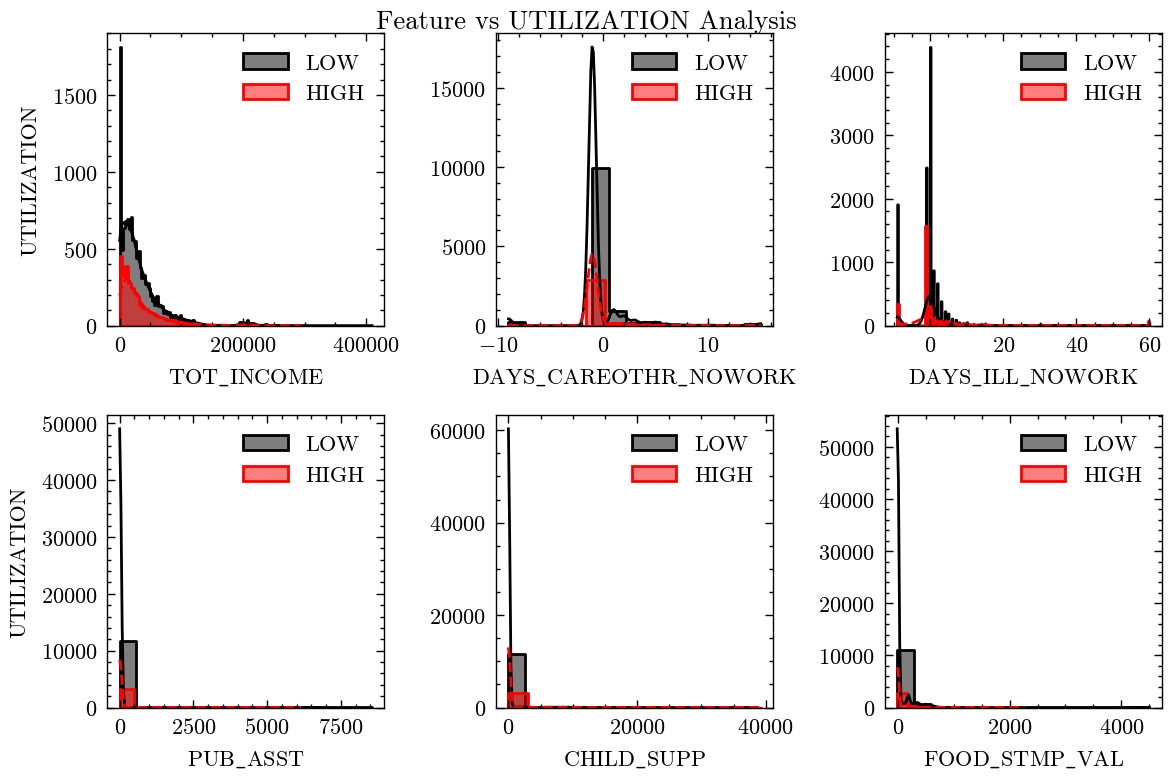

In [17]:
if not NO_PLOTS:
    plots.plot_features_vs_target(
        df_train,
        CLF_TARGET,
        figsize=(6, 4),
        features=numerical_cols,
        style=PAPER_STYLE,
        n_features=6,
        max_rows=2,
        is_categorical=True,
        categorical_legend=CLASS_MAPPING,
        x_log_scale=False,
    )

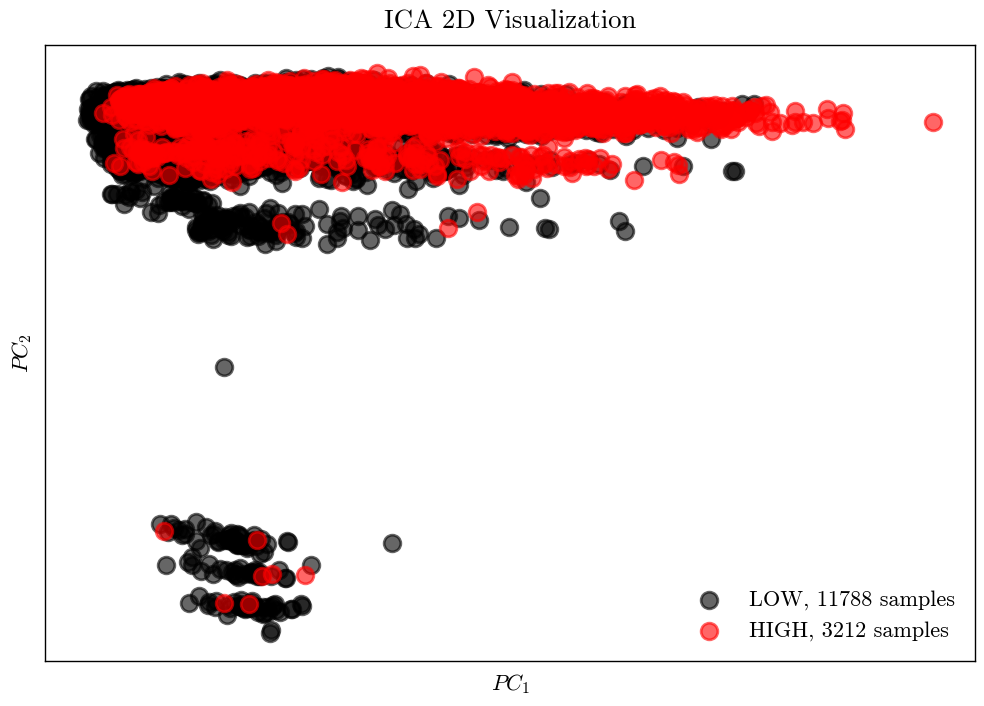

In [18]:
# Count the number of positive and negative samples
pos_samples = (df_train[CLF_TARGET] == 1).sum()
neg_samples = (df_train[CLF_TARGET] == 0).sum()

if not NO_PLOTS:
    plots.visualize(
        df_train.drop(columns=[CLF_TARGET] + correlated_cols),
        n_components=2,
        method="ica",
        indices=[df_train[CLF_TARGET] == 0, df_train[CLF_TARGET] == 1],
        labels=[
            f"{CLASS_MAPPING[0]}, {neg_samples} samples",
            f"{CLASS_MAPPING[1]}, {pos_samples} samples",
        ],
        style=PAPER_STYLE,
    )

# **Linear classification**

In this part, we will train a simple linear classification model to predict our target `UTILIZATION`.


We will first change our targets (classes: LOW, HIGH) to numeric targets. Then, we solve a logistic regression problem by minimizing the binary cross-entropy function

$$
J(\theta) = -\frac{1}{n} \sum_{i=1}^{n} \left( y_i \log(p_{\theta}(\hat{y}=1 | \mathbf{x}_i)) + (1 - y_i) \log(p_{\theta}(\hat{y}=0 | \mathbf{x}_i)) \right)
$$

where $y_i \in \{0, 1\}$ and $p_{\theta}(\hat{y}=k | \mathbf{x}_i)$ is the probability assigned by our model to class $k$ having observed features $\mathbf{x}_i$.

0 refers to HIGH, and 1 refers to LOW

### Setup

In [19]:
RUNS_DIR = "classification_task_runs"

helpers.ensure_directory_exists(RUNS_DIR)

In [20]:
# Split into features and target for classification
X = df_train.drop(columns=[CLF_TARGET])
y = df_train[CLF_TARGET]

print(f"Class mapping of column {CLF_TARGET}: {CLASS_MAPPING}\n")
value_counts_dict = y.value_counts().to_dict()

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}", f", value counts in y: {value_counts_dict}")

Class mapping of column UTILIZATION: {1: 'LOW', 0: 'HIGH'}

Shape of X: (15000, 429)
Shape of y: (15000,) , value counts in y: {1.0: 11788, 0.0: 3212}


### Process the data

In [21]:
X_train, X_test, y_train, y_test = helpers.make_train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

Training shape: (12000, 429)
Testing shape: (3000, 429)


### Fit the model by using training data

In [22]:
RUN_EXPERIMENTS = False
if RUN_EXPERIMENTS:
    CLASS_MAPPING = {1: "LOW", 0: "HIGH"}

    # Remove Correlated + Encode (+Likely Categorical)
    # dummy_is_categorical=True,
    # encode_after_remove_correlated=True,
    # consecutive_sequences_are_categorical=True,
    # low_unique_int_values_are_categorical=True,

    # Encode (+Likely Categorical) + Remove Correlated
    # dummy_is_categorical=True,
    # encode_after_remove_correlated=False,
    # consecutive_sequences_are_categorical=True,
    # low_unique_int_values_are_categorical=True,

    # Encode + Remove Correlated
    # dummy_is_categorical=True,
    # encode_after_remove_correlated=False,
    # consecutive_sequences_are_categorical=False,
    # low_unique_int_values_are_categorical=False,

    df_train, categorical_encoder, categorical_cols, numerical_cols, correlated_cols, data = (
        experiments.prepare_df_train_pipeline(
            "data/train.csv",
            CLF_TARGET,
            target_is_categorical=True,
            target_categorical_mapping=CLASS_MAPPING,
            remove_cols=[REG_TARGET],
            remove_correlated=True,
            correlation_threshold=CORRELATION_THRESHOLD,
            dummy_is_categorical=True,
            encode_after_remove_correlated=True,
            consecutive_sequences_are_categorical=True,
            low_unique_int_values_are_categorical=True,
            test_size=TEST_SIZE,
            random_state=RANDOM_STATE,
            stratify=True,
            tabs=1,
        )
    )

    df_train_desc = helpers.describe_cols(
        df_train,
        tabs=1,
        dummy_is_categorical=True,
        consecutive_sequences_are_categorical=False,
        low_unique_int_values_are_categorical=False,
    )

    X_train, y_train, X_test, y_test = data

    pipeline = experiments.preprocessing_pipeline2(
        drop_columns=correlated_cols, numerical_scaler=StandardScaler()
    )
    pipeline = experiments.extend_pipeline(
        pipeline,
        ("classifier", None),
    )

    # Define the parameter grid
    base_param_grid = {
        # Classifiers
        "classifier": [
            GradientBoostingClassifier(),
            XGBClassifier()
        ],
    }

    # Make a list of param grids by combining the preprocessing and classifier hyperparameters
    param_grids = construct_param_grids_list(base_param_grid, key="classifier")

    # Iterate over each classifier
    tuning.run_model_search(
        X_train,
        y_train,
        X_test,
        y_test,
        param_grids,
        pipeline,
        task_type="classification",
        refit_classification="f1-score",
        output_dir=RUNS_DIR,
        run_dir_suffix="XGBClassifier",
        additional_save_on_run={
            "categorical_encoder": (categorical_encoder, "pkl"),
            "categorical_cols": (categorical_cols, "pkl"), 
            "numerical_cols": (numerical_cols, "pkl"),
            "correlated_cols": (correlated_cols, "txt"),
            "df_train_desc": (df_train_desc, "txt"),
        },
        use_cuml=USE_CUML,
        subset=1,
        tabs=1,
        verbose=10,
    )

2024-08-22 20:09:10,795 - adjustText - DEBUG - Auto-explode radius: 57.01190476190476
2024-08-22 20:09:10,797 - adjustText - DEBUG - Adjustment took 1 iterations
2024-08-22 20:09:10,797 - adjustText - DEBUG - Time: 0.004654923999623861
2024-08-22 20:09:10,798 - adjustText - DEBUG - Error: 0.0


/home/camilo/Repositorios/ml-healthcare-project/utils/plots.py:300: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


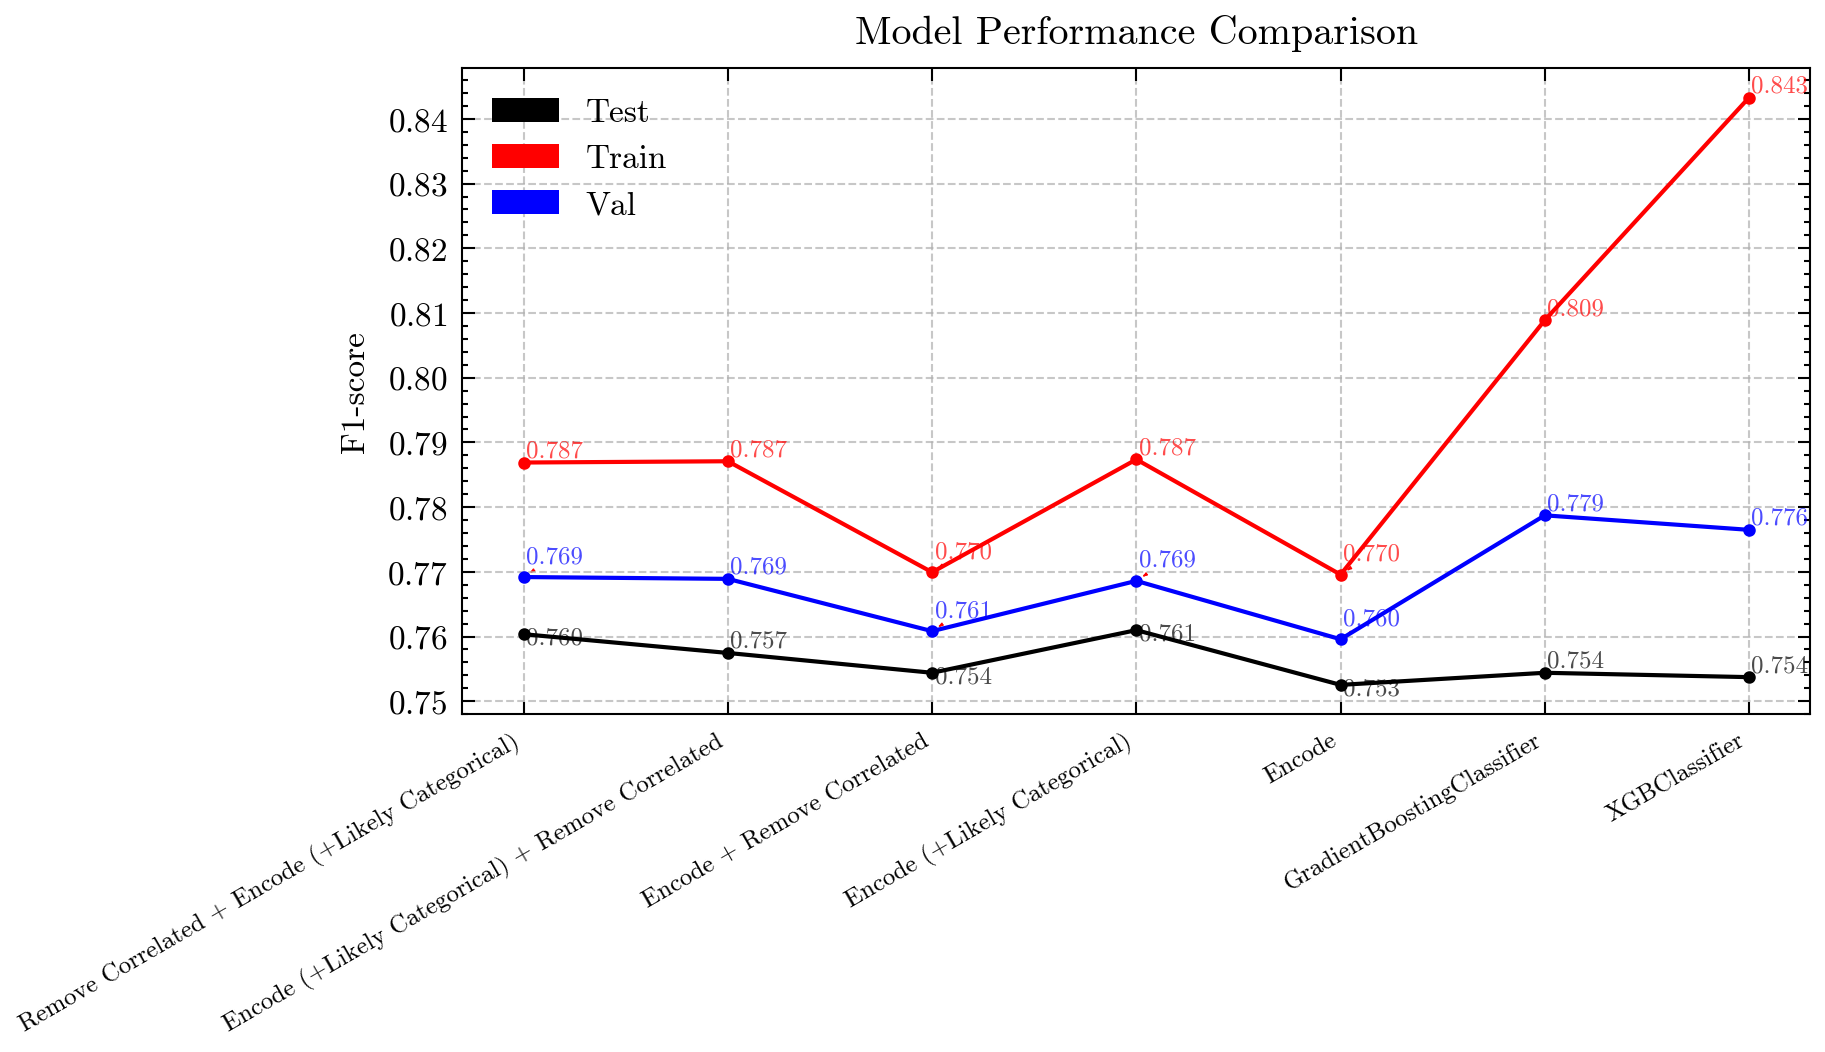

In [23]:
summary_df = tuning.plot_runs(
    RUNS_DIR,
    ["f1-score"],
    # only_runs_with_suffix=["Default_Pipeline2", "MoreCorrelatedFeaturesRemoved", "WithoutOneHotEncoding_Likely"],
    # runs_names_mapping={
    #     "Default_Pipeline2": "Default Pipeline",
    #     "MoreCorrelatedFeaturesRemoved": "More Correlated Features Removed",
    #     "WithoutOneHotEncoding_Likely": "Without One-Hot Encoding",
    # },
    summary_table=True,
    figsize=(6, 3),
    title="Model Performance Comparison",
    style=PAPER_STYLE,
    save_path=os.path.join(RUNS_DIR, "performance_comparison"),
    save_format="pdf",
    xtick_rotation=30,
    xtick_size=6,
    annotate_values=True,
    grid=True
)

Now evaluate your model. Check the appendix for details on micro, macro and weighted averaging

In [24]:
best_run = "run_20240822_193558_GradientBoostingClassifier_GradientBoostingClassifier"
best_classifier = tuning.load_run_model(os.path.join(RUNS_DIR, best_run))
best_classifier_name = best_run.split("_")[-2]
categorical_encoder = tuning.load_from_run(os.path.join(RUNS_DIR, best_run), "categorical_encoder")
categorical_cols = tuning.load_from_run(os.path.join(RUNS_DIR, best_run), "categorical_cols")
X_train, y_train, X_test, y_test = tuning.load_from_run(os.path.join(RUNS_DIR, best_run), "data")

Loading classification_task_runs/run_20240822_193558_GradientBoostingClassifier_GradientBoostingClassifier/final_estimator.pkl ... Done.
Loading classification_task_runs/run_20240822_193558_GradientBoostingClassifier_GradientBoostingClassifier/categorical_encoder.pkl ... Done.
Loading classification_task_runs/run_20240822_193558_GradientBoostingClassifier_GradientBoostingClassifier/categorical_cols.pkl ... Done.
Loading classification_task_runs/run_20240822_193558_GradientBoostingClassifier_GradientBoostingClassifier/data.pkl ... Done.


In [25]:
datasets = {"training data": [X_train, y_train], "validation data": [X_test, y_test]}

for split_name, dataset in datasets.items():
    X_i, y_i = dataset
    y_pred = best_classifier.predict(X_i)
    print(f"\nSplit: {split_name}")

    print(skm.classification_report(y_i, y_pred))


Split: training data
              precision    recall  f1-score   support

           0       0.78      0.61      0.69      2570
           1       0.90      0.95      0.93      9430

    accuracy                           0.88     12000
   macro avg       0.84      0.78      0.81     12000
weighted avg       0.87      0.88      0.87     12000


Split: validation data
              precision    recall  f1-score   support

           0       0.68      0.54      0.60       642
           1       0.88      0.93      0.91      2358

    accuracy                           0.85      3000
   macro avg       0.78      0.74      0.75      3000
weighted avg       0.84      0.85      0.84      3000



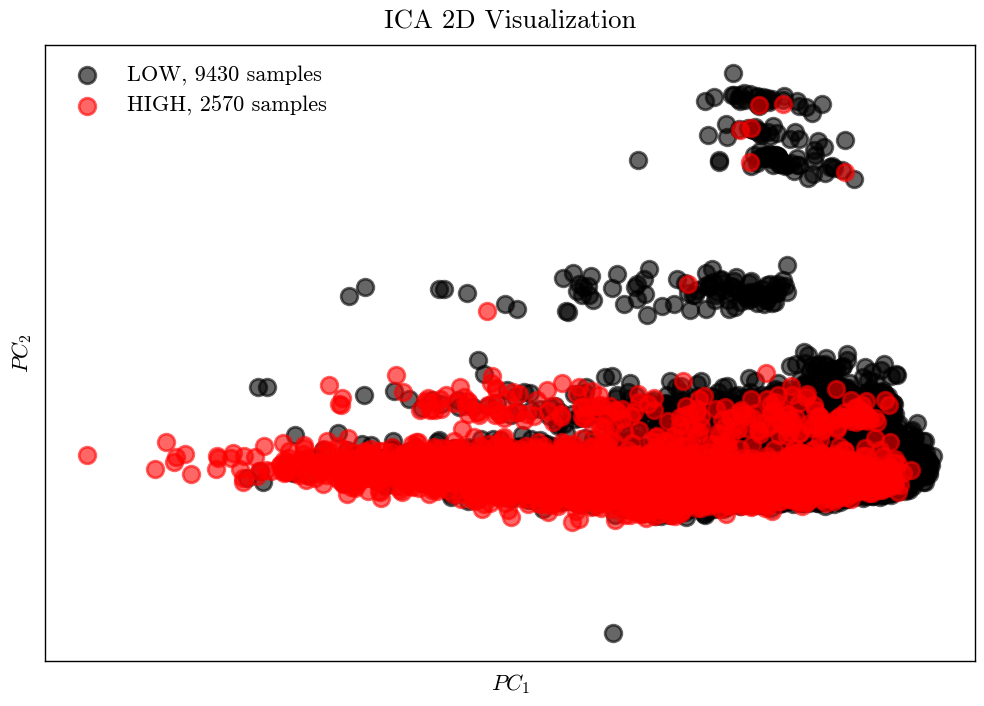

In [26]:
X_transformed = best_classifier[:-1].transform(X_train)

if not NO_PLOTS:
    plots.visualize(
        X_transformed,
        n_components=2,
        method="ica",
        indices=[y_train == 0, y_train == 1],
        labels=[
            f"{CLASS_MAPPING[0]}, {len(y_train[y_train == 0])} samples",
            f"{CLASS_MAPPING[1]}, {len(y_train[y_train == 1])} samples",
        ],
        style=PAPER_STYLE,
    )

/home/camilo/Repositorios/ml-healthcare-project/utils/plots.py:980: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


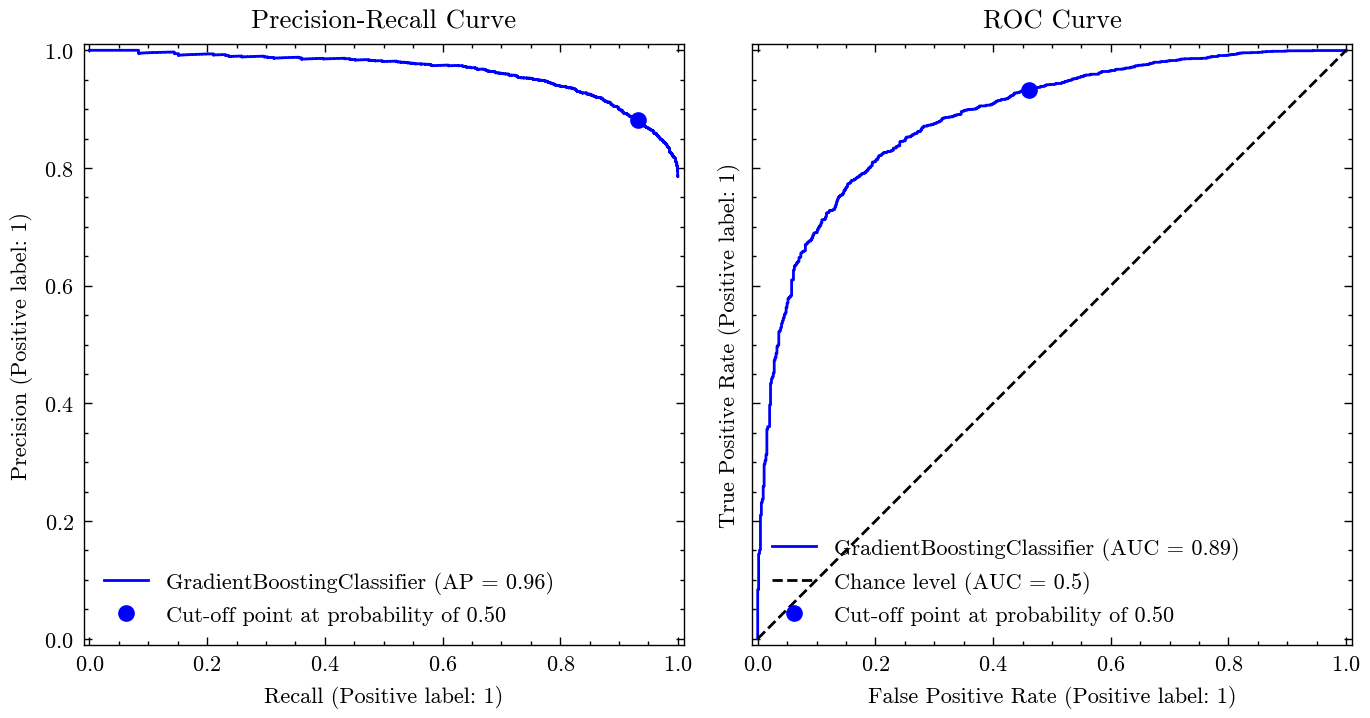

In [27]:
plots.plot_pr_roc_curves(
    best_classifier,
    X_test,
    y_test,
    clf_name=best_classifier_name,
    style=PAPER_STYLE,
)

In [28]:
print(
    f"Original f1-score: {scorers.clf_scorers['f1_macro'](best_classifier, X_test, y_test)}"
)

tuned_model = TunedThresholdClassifierCV(
    estimator=best_classifier,
    scoring=scorers.clf_scorers["f1_macro"],
    store_cv_results=True,
)
tuned_model.fit(X_train, y_train)
print(f"{tuned_model.best_threshold_ = :0.2f}")
print(
    f"After tuning f1-score: {scorers.clf_scorers['f1_macro'](tuned_model, X_test, y_test)}"
)

Original f1-score: 0.7544027966483882
tuned_model.best_threshold_ = 0.60
After tuning f1-score: 0.7652620603440276


/home/camilo/Repositorios/ml-healthcare-project/utils/plots.py:980: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


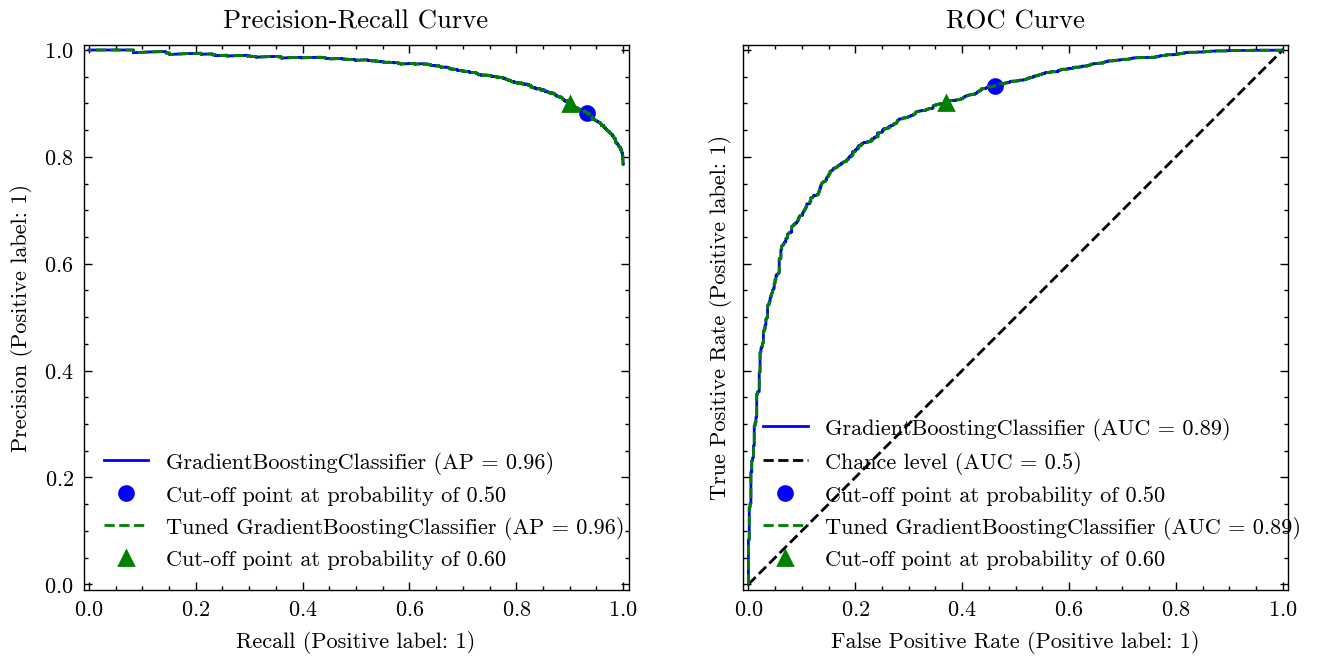

In [29]:
# Comparison of the cut-off point for the vanilla and tuned model
plots.plot_pr_roc_curves(
    best_classifier,
    X_test,
    y_test,
    tuned_model,
    clf_name=best_classifier_name,
    show_objective_score=False,
    style=PAPER_STYLE,
)

In [30]:
datasets = {"training data": [X_train, y_train], "validation data": [X_test, y_test]}

for split_name, dataset in datasets.items():
    X_i, y_i = dataset
    y_pred = tuned_model.predict(X_i)
    print(f"\nSplit: {split_name}")

    print(skm.classification_report(y_i, y_pred))


Split: training data
              precision    recall  f1-score   support

           0       0.72      0.70      0.71      2570
           1       0.92      0.93      0.92      9430

    accuracy                           0.88     12000
   macro avg       0.82      0.81      0.81     12000
weighted avg       0.87      0.88      0.88     12000


Split: validation data
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       642
           1       0.90      0.90      0.90      2358

    accuracy                           0.84      3000
   macro avg       0.77      0.76      0.77      3000
weighted avg       0.84      0.84      0.84      3000



At this point, we can use our model to predict healthcare utilization on the test set.

We again need to follow a specific namim format when saving the predictions. Similarly to before, the name of the file should be `<TEAM_ID>__<SPLIT>__clf_pred.npy`.



In [31]:
best_classifier = tuned_model

In [32]:
# Run this to save a file with your predictions on the test set to be submitted
split = "test_public"  # replace by 'test_private' for FINAL submission

df_test = pd.read_csv(f"data/{split}.csv")

# Process data
# Make sure that we keep only the categorical cols that exist here
categorical_cols = helpers.remove_non_existent_columns(categorical_cols, df_test.columns)

# Handle the categorical columns in the test set
df_test = helpers.encode_categorical_cols(
    df_test, categorical_cols, categorical_encoder, return_only_encoded=False
)

y_hat = best_classifier.predict(df_test)

# Save the results with the format <TEAM_ID>__<SPLIT>__clf_pred.npy

folder = "./results"
np.save(os.path.join(folder, f"{team_id}__{split}__clf_pred.npy"), y_hat)

/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [63] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Submission to CMS

Put your .npy files for both regression and classification tasks in the same zip file. Please name the file as `<TEAM_ID>.zip` (e.g. `123.zip`) and upload it to CMS system. It is essential that the files inside the .zip are named as follow:

`<TEAM_ID>__<SPLIT>__reg_pred.npy` \
`<TEAM_ID>__<SPLIT>__clf_pred.npy`

Above, `<SPLIT>` should correspond to `test_public` for the leaderboard and `test_private` for the final submission.
As long as the `test_private.csv` data file is not released yet, the zip will contain only two files.


### Appendix: Reminders about macro and micro averaging:

When evaluating a classification model using `skm.classification_report(y_i, y_pred)` as done above, we get a macro and a weighted average.

In the context of computing F1-score, "macro" and "micro" averaging are two commonly used techniques to aggregate the per-class F1-scores.

**Micro-average**: Compute the F1-score globally by counting the total true positives, false negatives, and false positives over all classes, and then calculating precision, recall, and F1-score using these aggregated values.

**Macro-average**: Calculate the F1-score for each class separately, and then take the average of these per-class F1-scores.

The main difference between these two techniques is the way they treat class imbalance. Micro-average treats all classes equally, regardless of their size, while macro-average treats each class equally, regardless of the number of samples in that class.

Micro-average is often used when we care about overall performance across all classes, and we want to give more weight to the performance on larger classes. In contrast, macro-average is often used when we want to evaluate the performance on each class separately and give equal weight to each class.


In addition to micro and macro averaging, there is another common technique for computing the F1-score called **weighted averaging**.

**Weighted averaging** is similar to macro averaging in that it computes the per-class F1-score and then takes the average of these scores. However, unlike macro averaging, weighted averaging takes into account the number of samples in each class when computing the average. Specifically, the weighted average is computed as follows:

- Compute the F1-score for each class separately.
- Compute the weight for each class as the number of samples in that class divided by the total number of samples.
- Compute the weighted average of the per-class F1-scores, where each per-class F1-score is weighted by the weight of that class.

The weighted average is commonly used when the dataset is imbalanced, meaning that some classes have many more samples than others. In such cases, using the simple average (macro-average) would give too much weight to the smaller classes, while using micro-average would give too much weight to the larger classes. The weighted average strikes a balance between these two approaches by giving more weight to the classes with more samples while still taking into account the performance of all classes.


When computing the F1 score for the leaderboard and the final challenge results, we will be using the macro averaging strategy.